<a href="https://colab.research.google.com/github/varshaa-118/Demand-Forecasting/blob/main/demand_forecast_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gc



In [ ]:
!pip install --quite prophet



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --quite


In [ ]:
# Load datasets
sales_df = pd.read_csv('/content/drive/MyDrive/demand pred/sales data-set.csv')  # Replace with your file name
features_df = pd.read_csv('/content/drive/MyDrive/demand pred/Features data set.csv')
stores_df = pd.read_csv('/content/drive/MyDrive/demand pred/stores data-set.csv')

# Display samples
print(sales.head())
print(features.head())
print(stores.head())


   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211

In [ ]:
# Convert 'Date' to datetime
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d/%m/%Y')
features_df['Date'] = pd.to_datetime(features_df['Date'], format='%d/%m/%Y')

# Merge all datasets
data = pd.merge(sales_df, features_df, on=['Store', 'Date', 'IsHoliday'], how='left')
data = pd.merge(data, stores_df, on='Store', how='left')

# Handle missing values
data.fillna(0, inplace=True)

# Sort by date
data = data.sort_values('Date')


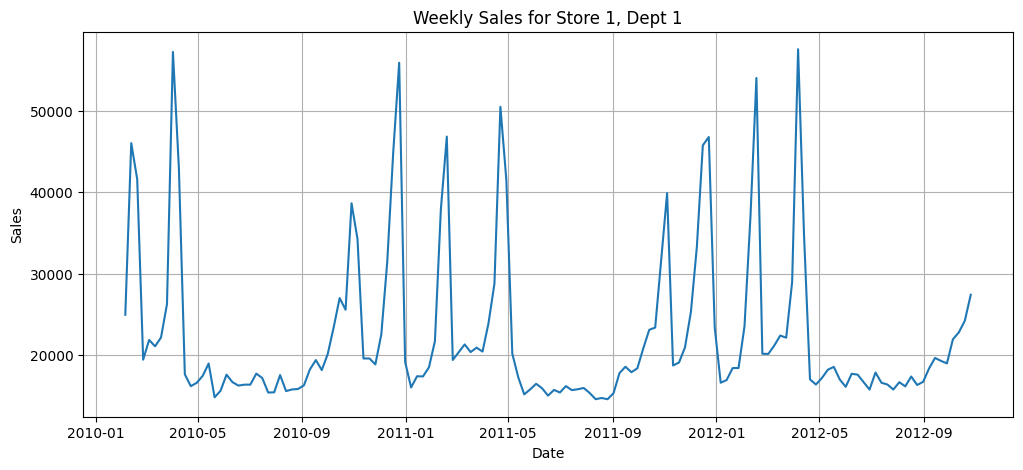

In [ ]:
df = data[(data['Store'] == 1) & (data['Dept'] == 1)]

# Keep only necessary columns
df = df[['Date', 'Weekly_Sales']].groupby('Date').sum().reset_index()

# Rename columns for Prophet
df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

# Plot data
plt.figure(figsize=(12,5))
plt.plot(df['ds'], df['y'])
plt.title('Weekly Sales for Store 1, Dept 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6c9wtp/m4rhtljw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6c9wtp/ikyir6v7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11383', 'data', 'file=/tmp/tmpxl6c9wtp/m4rhtljw.json', 'init=/tmp/tmpxl6c9wtp/ikyir6v7.json', 'output', 'file=/tmp/tmpxl6c9wtp/prophet_model79y9sg3n/prophet_model-20250411103209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:32:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


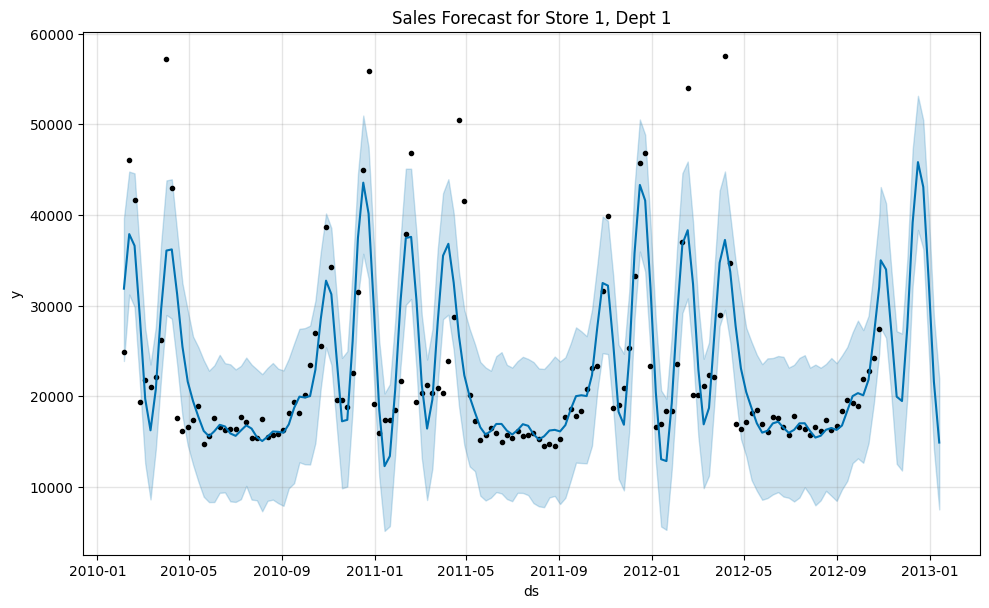

In [ ]:
# Initialize and train model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df)

# Forecast next 12 weeks
future = model.make_future_dataframe(periods=12, freq='W')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Sales Forecast for Store 1, Dept 1")
plt.show()


In [ ]:
print("Full dataset date range:")
print(df['ds'].min(), "to", df['ds'].max())


Full dataset date range:
2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [ ]:
split_date = '2012-06-01'  # Make sure it's within your range
train = df[df['ds'] < split_date]
test = df[df['ds'] >= split_date]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 121
Test size: 22


In [ ]:
train = df[df['ds'] < split_date]
test = df[df['ds'] >= split_date]

# Reinitialize and train model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(train)

# Make future dataframe with exact test weeks
future = model.make_future_dataframe(periods=len(test), freq='W')

# Predict
forecast = model.predict(future)

# Match only forecast rows that are in test set dates
predicted = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')

# Sanity check
print("Forecast end date:", future['ds'].max())
print("Test start date:", test['ds'].min())
print("Matched rows:", len(predicted))


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6c9wtp/ro4oe20l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6c9wtp/e4yjl1_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79773', 'data', 'file=/tmp/tmpxl6c9wtp/ro4oe20l.json', 'init=/tmp/tmpxl6c9wtp/e4yjl1_z.json', 'output', 'file=/tmp/tmpxl6c9wtp/prophet_modeld90psdqi/prophet_model-20250411103301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecast end date: 2012-10-21 00:00:00
Test start date: 2012-06-01 00:00:00
Matched rows: 0


In [ ]:
# Convert test dates to list of strings
test_dates = test['ds'].dt.strftime('%Y-%m-%d').tolist()

# Convert forecast dates to same format
forecast['ds_str'] = forecast['ds'].dt.strftime('%Y-%m-%d')

# Filter forecast to only rows where date matches test set
filtered_forecast = forecast[forecast['ds_str'].isin(test_dates)]

# Add actual values (y) from test set
predicted = filtered_forecast.merge(test[['ds', 'y']], left_on='ds', right_on='ds', how='inner')

print("✅ Matched rows:", len(predicted))


✅ Matched rows: 0


In [ ]:
# Round both test and forecast dates to Mondays
test['ds'] = pd.to_datetime(test['ds']).dt.to_period('W').dt.start_time
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('W').dt.start_time


<ipython-input-26-f06b377db0c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds']).dt.to_period('W').dt.start_time


In [ ]:
# Merge on rounded week start date
predicted = forecast[['ds', 'yhat']].merge(test[['ds', 'y']], on='ds', how='inner')

print("✅ Matched rows after aligning by week:", len(predicted))


✅ Matched rows after aligning by week: 21


In [ ]:
if len(predicted) > 0:
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(predicted['y'], predicted['yhat'])
    rmse = np.sqrt(mean_squared_error(predicted['y'], predicted['yhat']))

    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ RMSE: {rmse:.2f}")
else:
    print("❌ Still no match — please check if forecast covers test dates.")


✅ MAE: 1098.13
✅ RMSE: 1717.36


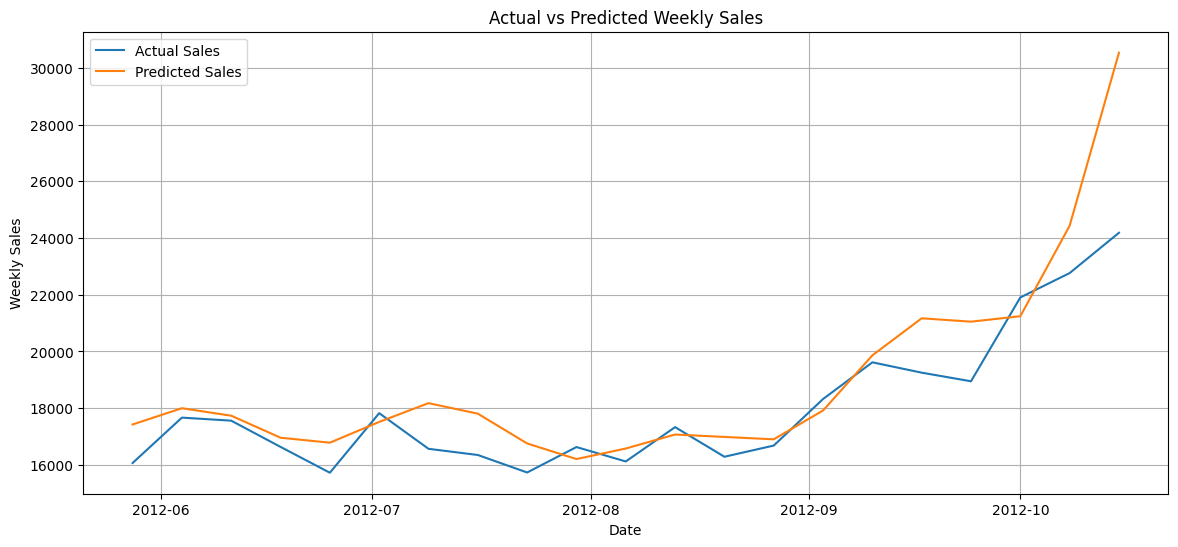

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(predicted['ds'], predicted['y'], label='Actual Sales')
plt.plot(predicted['ds'], predicted['yhat'], label='Predicted Sales')
plt.title("Actual vs Predicted Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid()
plt.show()
